# Tree Data Preparation for Tree Explainer

lucsan - June 2021

In [33]:
import pandas as pd
import re
import numpy as np
import graphviz
import six
import json
import random

import sklearn
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

## Read raw data and prepare it - CAN SKIP IF YOU'RE REUSING DATA

In [2]:
df = pd.read_csv("data/14.08.07-annual-tree-data-file.csv")
len(df)

42226

In [3]:
df.head()

,Location,Ward,Address,Height,Diameter,Age Class,Species,Unnamed: 7,Unnamed: 8
0,Outside 0 (Sunny Gardens Parade),Hendon (A) \n,Sunny Gardens Parade ...,17.5m,80cm,Mature,Catalpa bignonioides \n,NaN,NaN
1,Outside (The Burroughs Library),Hendon (A) \n,The Burroughs Library ...,3.0m,8cm,,Vacant Treepit \n,NaN,NaN
2,Outside (The Burroughs Library),Hendon (A) \n,The Burroughs Library ...,3.0m,8cm,,Void Treepit \n,NaN,NaN
3,Outside (The Burroughs Library),Hendon (A) \n,The Burroughs Library ...,3.0m,20cm,Semi-Mature,Cryptomeria japonica \n,NaN,NaN
4,Outside (The Burroughs Library),Hendon (A) \n,The Burroughs Library ...,3.0m,12cm,Early,Fraxinus excelsior Pendula \n,NaN,NaN


In [4]:
keep_cols = ["Height", "Diameter", "Age Class", "Ward", "Species"]
df = df[keep_cols]

In [5]:
# Util functions

def strip_line_break(row):
    row = row.strip()
    if row == "":
        row = None
    return row
    
def strip_empty_space(row):
    if re.match(r"\s+", row):
        return None
    else:
        return row
    
def strip_measure(row):
    regex = r"(\d+\.?\d?)(\w+)"
    match = re.findall(regex, row)[0]
    if match[1] == "m":
        return float(match[0])
    elif match[1] == "cm":
        return float(match[0])/100
    else:
        print(row)
        
def extract_tree_family(row):
    return row.split()[0]

In [6]:
df = df.dropna(how="any")
df["Ward"] = df["Ward"].apply(strip_empty_space)
df = df.dropna(how="any")
df["Ward"] = df["Ward"].apply(strip_line_break)
df["Ward"] = df["Ward"].apply(lambda row: row[:-4])

In [7]:
df["Age Class"] = df["Age Class"].apply(strip_empty_space)
df = df.dropna(how="any")
df["Age Class"] = df["Age Class"].apply(strip_line_break)
df["Age Class"] = df["Age Class"].apply(lambda r: None if r=="N/A" else r)
df = df.dropna(how="any")

In [8]:
df = df.dropna(how="any")
df["Species"] = df.Species.apply(strip_line_break)
df = df.dropna(how="any")

In [9]:
df["Height"] = df.Height.apply(strip_measure)
df["Diameter"] = df.Diameter.apply(strip_measure)

In [10]:
df["Family"] = df.Species.apply(extract_tree_family)
# Remove some erroneous family names
wrong_family = ["Other", "Mixed", "Void", "Various", "Vacant"]
df = df[~df.Family.isin(wrong_family)]
df["Family"] = df.Family.apply(lambda r: "Liquidamber" if r=="Liquidambar" else r)

In [11]:
df.head()

,Height,Diameter,Age Class,Ward,Species,Family
0,17.5,0.80,Mature,Hendon,Catalpa bignonioides,Catalpa
3,3.0,0.20,Semi-Mature,Hendon,Cryptomeria japonica,Cryptomeria
4,3.0,0.12,Early,Hendon,Fraxinus excelsior Pendula,Fraxinus
5,3.0,0.16,Early,Hendon,Fraxinus excelsior Pendula,Fraxinus
7,7.5,0.60,Semi-Mature,Burnt Oak,Quercus robur,Quercus


In [12]:
# Add the counts of species and families as columns

dict_counts_species = df.Species.value_counts().to_dict()
dict_counts_family = df.Family.value_counts().to_dict()

df["num_examples_species"] = df.Species.apply(lambda r: dict_counts_species[r])
df["num_examples_family"] = df.Family.apply(lambda r: dict_counts_family[r])

In [13]:
# Add the counts of families and age classes

dfg = df.groupby(["Family", "Age Class"]).agg({"Height": ["mean", "std"], 
                                         "Diameter": ["mean", "std"],
                                         "num_examples_family": "count"}).reset_index()

new_cols = ["Family", "Age Class", "Height_mean", "Height_std", "Diameter_mean", "Diameter_std", "num"]
dfg.columns = new_cols
dfg.head()

,Family,Age Class,Height_mean,Height_std,Diameter_mean,Diameter_std,num
0,Abies,Early Mature,3.571429,1.511858,0.210,0.074386,7
1,Abies,Mature,5.250000,3.181981,0.275,0.106066,2
2,Abies,Semi-Mature,4.500000,NaN,0.290,NaN,1
3,Abies,Young,2.333333,0.577350,0.060,0.017321,3
4,Acacia,Semi-Mature,9.500000,NaN,0.320,NaN,1


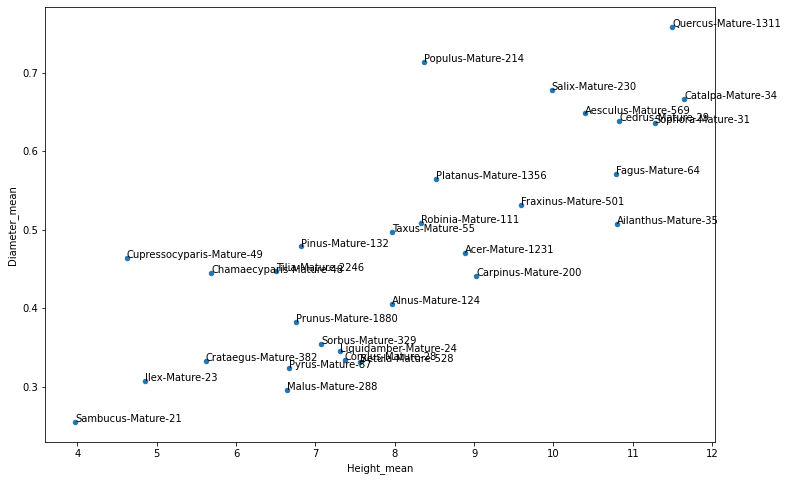

In [14]:
fig, ax = plt.subplots()
dfpl = dfg[(dfg.num>=20) & (dfg["Age Class"]=="Mature")]
dfpl.plot.scatter(x="Height_mean", y="Diameter_mean", figsize=(12,8), ax=ax)
for (k, row) in dfpl.iterrows():
    ax.annotate("-".join([row["Family"],
                          row["Age Class"],
                          str(row["num"])]), (row["Height_mean"], row["Diameter_mean"]), rotation=0)

In [15]:
DF = pd.merge(df, dfg, on=["Family", "Age Class"])
DF.head()

,Height,Diameter,Age Class,Ward,Species,Family,num_examples_species,num_examples_family,Height_mean,Height_std,Diameter_mean,Diameter_std,num
0,17.5,0.80,Mature,Hendon,Catalpa bignonioides,Catalpa,69,79,11.647059,4.22928,0.666471,0.195307,34
1,3.0,0.55,Mature,Garden Suburb,Catalpa bignonioides Aurea,Catalpa,10,79,11.647059,4.22928,0.666471,0.195307,34
2,3.0,0.45,Mature,Garden Suburb,Catalpa bignonioides Aurea,Catalpa,10,79,11.647059,4.22928,0.666471,0.195307,34
3,7.5,0.45,Mature,Hale,Catalpa bignonioides,Catalpa,69,79,11.647059,4.22928,0.666471,0.195307,34
4,18.5,0.89,Mature,Colindale,Catalpa bignonioides,Catalpa,69,79,11.647059,4.22928,0.666471,0.195307,34


## Hand pick 3 families for the data set

In [16]:
# Plotting util function
def plot_data(data, features=["Height", "Diameter"], mirror=False):
    if mirror:
        features = features[::-1]
    cols = ["tab:red", "tab:blue", "tab:green"]
    dict_cols_fam = {k: v for (k, v) in zip(data.Family.unique(), cols)}

    fig, ax = plt.subplots()
    grouped_fam = data.groupby('Family')
    for key, group in grouped_fam:
        group.plot(ax=ax, kind='scatter', x=features[0], y=features[1], figsize=(8,7), 
                   label=key, color=dict_cols_fam[key])
    plt.show()


Original data set size:
Sorbus      197
Populus     134
Sambucus     54
Name: Family, dtype: int64


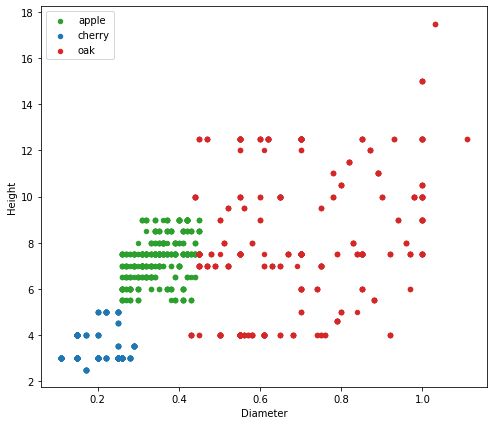

In [17]:
# Tweak a bit the ages so that the families are somehow separable
chosen_pars = {
    "Sambucus": ["Early", "Early Mature", "Semi-Mature"],
    "Sorbus": ["Mature"],
    "Populus": ["Mature", "Over-Mature"]
}

# Remove data points that are very far from the mean to not have crazy outliers
thr = 1
dffil = DF[(np.abs(DF.Height-DF.Height_mean)<=thr*DF.Height_std) & (np.abs(DF.Diameter-DF.Diameter_mean)<=thr*DF.Diameter_std)]

# Pick the data from the filtered data frame
dfs = []
for (fam, ages) in chosen_pars.items():
    dfsel = dffil[(dffil.Family==fam) & (dffil["Age Class"].isin(ages))]
    dfs.append(dfsel)
dfs = pd.concat(dfs)

print("Original data set size:")
print(dfs.Family.value_counts())

# Upsample the 3 families to have 600 data points on each
g = dfs.groupby(["Family"], group_keys=False)
dfs = pd.DataFrame(g.apply(lambda x: x.sample(600, replace=True).reset_index(drop=True)))

# Rename tree families to simplify
map_families = {"Populus": "oak", "Sorbus": "apple", "Sambucus": "cherry"}
dfs["Family"] = dfs.Family.apply(lambda r: map_families[r])

plot_data(dfs, mirror=True)

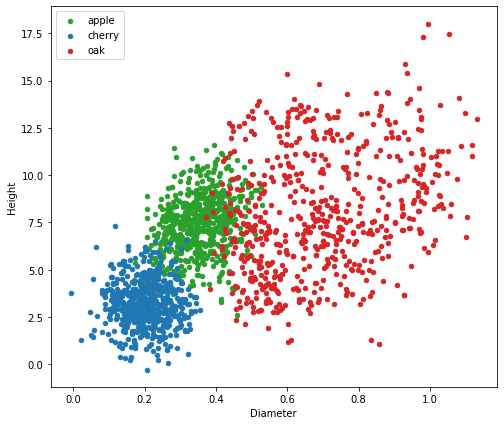

In [18]:
# Perturb Height and Diameter to get a more "random" data set
# Do it twice because it looks nicer
sigma_height = 0.8
sigma_diameter = 0.03
np.random.seed(1)
dfs["Height"] = dfs["Height"].apply(lambda row: row + np.random.normal(0, sigma_height))
dfs["Height"] = dfs["Height"].apply(lambda row: row + np.random.normal(0, sigma_height))

dfs["Diameter"] = dfs["Diameter"].apply(lambda row: row + np.random.normal(0, sigma_diameter))
dfs["Diameter"] = dfs["Diameter"].apply(lambda row: row + np.random.normal(0, sigma_diameter))

#dfs.loc[(dfs.Family=="cherry") & (dfs.Diameter<=0.25), "Diameter"] = dfs.loc[(dfs.Family=="cherry") & (dfs.Diameter<=0.25), "Diameter"] + np.random.normal(0, sigma_diameter) 
#dfs.loc[(dfs.Family=="cherry") & (dfs.Diameter<=0.25), "Height"] = dfs.loc[(dfs.Family=="cherry") & (dfs.Diameter<=0.25), "Height"] + np.random.normal(0, sigma_height) 

# Plot how it's looking like
plot_data(dfs, mirror=True)

## Create mini data sets for display

In [19]:
# Utilities to prune decision nodes that end up in the same class

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == sklearn.tree._tree.TREE_LEAF and 
            inner_tree.children_right[index] == sklearn.tree._tree.TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = sklearn.tree._tree.TREE_LEAF
        inner_tree.children_right[index] = sklearn.tree._tree.TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

In [20]:
def create_mini_set(data, sample_size):
    g = data.groupby(["Family"], group_keys=False)
    outdata = pd.DataFrame(g.apply(lambda x: x.sample(sample_size, replace=True).reset_index(drop=True)))
    return outdata

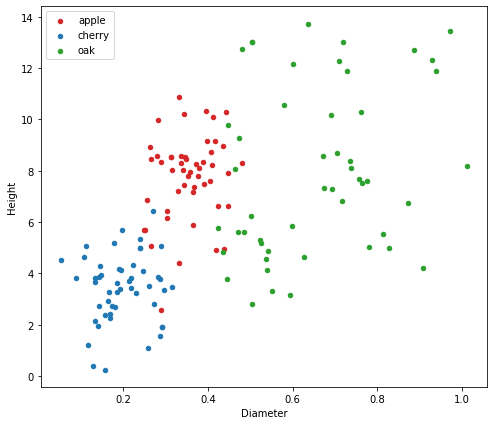

In [21]:
# One can create many different data sets with 30 points per family each. 
# We should probably set up a fixed random seed at some point
dfm = create_mini_set(dfs, 50)
plot_data(dfm, mirror=True)

In [25]:
dfm.to_csv("data/data_for_tree_Oct22.csv", index=False)

## Fit the decision tree

In [26]:
# Run this cell if fitting it from file data (rather than fresh generated data)
dfm = pd.read_csv("data/data_for_tree_Oct22.csv")

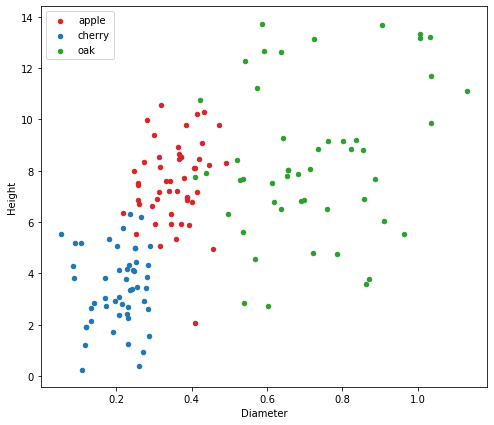

In [27]:
plot_data(dfm, mirror=True)

In [22]:
features = ["Height", "Diameter"]
X = dfm[features]
y = dfm["Family"]

In [37]:
parameters = {'max_depth': range(2,8)}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf=4), parameters, n_jobs=4)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.9133333333333333 {'max_depth': 4}


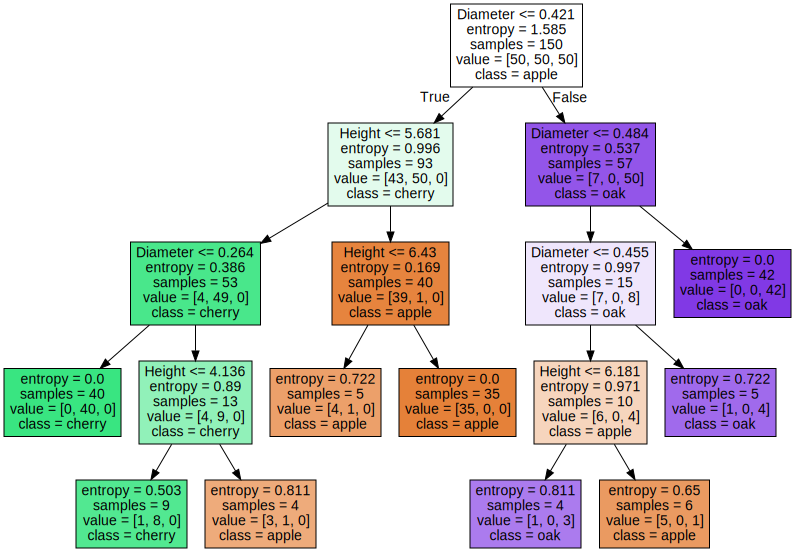

In [38]:
# prune_duplicate_leaves(tree_model)
# # DOT data
dot_data = tree.export_graphviz(tree_model, out_file=None, 
                                feature_names=features,  
                                class_names=y.unique(),
                                filled=True)

# Draw graph - scroll to the right to see the root of the tree
graph = graphviz.Source(dot_data, format="png") 
graph


In [24]:
tree_model.feature_importances_

array([0.34747341, 0.65252659])

<BarContainer object of 2 artists>

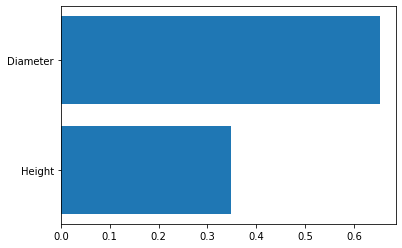

In [25]:
plt.barh(features, tree_model.feature_importances_)

## Visualize decision boundaries

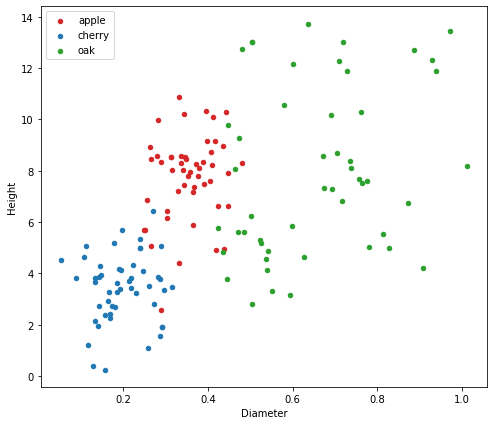

In [26]:
plot_data(dfm, mirror=True)

In [27]:
# Plotting util function
def plot_data_with_model(trained_model, data, features=["Height", "Diameter"], label="Family", 
                         mirror=False,  cmap="rainbow"):
    if mirror:
        features = features[::-1]
    cols = ["tab:red", "tab:blue", "tab:green"]
    dict_cols_fam = {k: v for (k, v) in zip(dfs.Family.unique(), cols)}

    fig, ax = plt.subplots()
    grouped_fam = data.groupby('Family')
    for key, group in grouped_fam:
        group.plot(ax=ax, kind='scatter', x=features[0], y=features[1], figsize=(8,7), 
                   label=key, color=dict_cols_fam[key])
        
    xlim = (data[features[0]].min(), data[features[0]].max())
    ylim = (data[features[1]].min(), data[features[1]].max())
    
    print(xlim)
    print(ylim)
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = trained_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Create a color plot with the results
    le = LabelEncoder()
    y = le.fit_transform(data[label])
    for i in range(Z.shape[0]):
        Z[:, i] = le.transform(Z[:, i])

    n_classes = len(np.unique(data[label]))
    print(n_classes)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)
    
    plt.show()

(0.05398653990744723, 1.0113151356833456)
(0.2541724674909841, 13.731744801123686)
3


/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/var/folders/q7/m68qws4n4fbbrcfnp46xfp5hwyhs2z/T/ipykernel_32857/1592925770.py:33: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


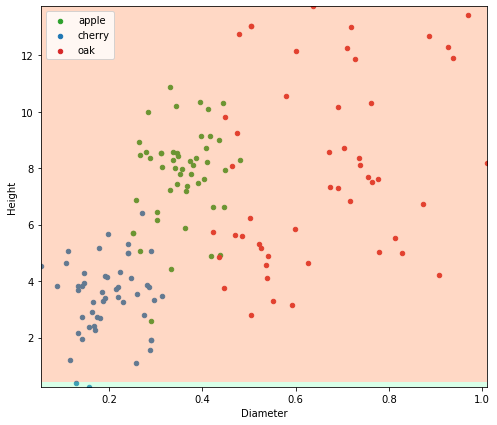

In [28]:
plot_data_with_model(tree_model, dfm, mirror=True)

In [29]:
def visualize_classifier(model, data, ax=None, cmap='rainbow', mirror="False"):
    ax = ax or plt.gca()
    
    features = ["Height", "Diameter"]
    label = "Family"
    if mirror: 
        features = features[::-1]
    X = data[features].to_numpy()
    y = LabelEncoder().fit_transform(data["Family"].to_numpy())
    
    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
                         clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    #ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)
                           

    ax.set(xlim=xlim, ylim=ylim)
    
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend1)
    
    return model

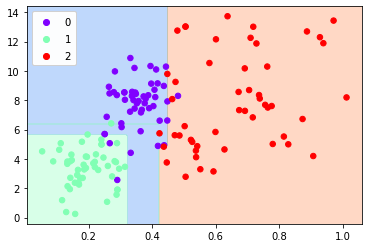

In [31]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, criterion="entropy"), dfm, mirror=True)

In [38]:
# DOT data
features = ["Diameter", "Height"]
dot_data = tree.export_graphviz(trained_clf, out_file=None, 
                                feature_names=features,  
                                class_names=["cherry", "apple", "oak"],
                                filled=True)

# Draw graph - scroll to the right to see the root of the tree
graph = graphviz.Source(dot_data, format="png") 
graph


NameError: name 'graphviz' is not defined

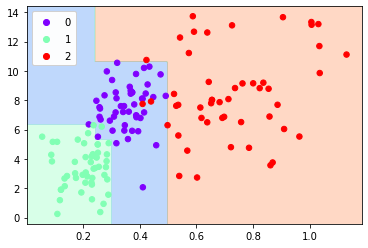

In [39]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4), dfm, mirror=True)

In [40]:
def is_in_bounds(h, d, hlim, dlim): 
    return (h >= hlim[0]) & (h <= hlim[1]) & (d >= dlim[0]) & (d <= dlim[1])

def perturb_data(data, sigma=1):
    
    df = data.copy(deep=True)
    
    max_h = df.Height.max()
    min_h = df.Height.min()
    max_d = df.Diameter.max()
    min_d = df.Diameter.min()
    
    ind = random.randint(0, len(df)-1)
    new_height = random.gauss(df.loc[ind, "Height"], sigma)
    new_diameter = random.gauss(df.loc[ind, "Diameter"], sigma)
    
    while not is_in_bounds(new_height, new_diameter, (min_h, max_h), (min_d, max_d)):
        ind = random.randint(0, len(df))
    
        # Perturb height and dimension with gaussian 
        new_height = random.gauss(df.loc[ind, "Height"], sigma)
        new_diameter = random.gauss(df.loc[ind, "Diameter"], sigma)
        
    df.loc[ind, "Height"] = new_height
    df.loc[ind, "Diameter"] = new_diameter
    
    return df
    

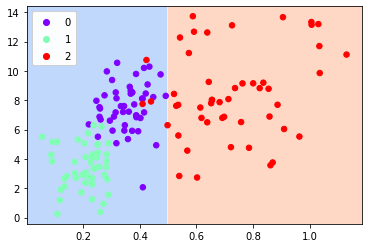

In [41]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=1), dfm, mirror=True)

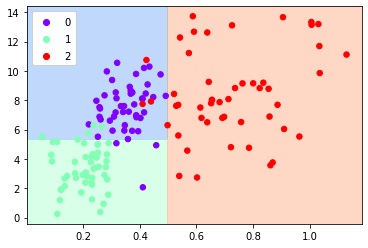

In [42]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=2), dfm, mirror=True)

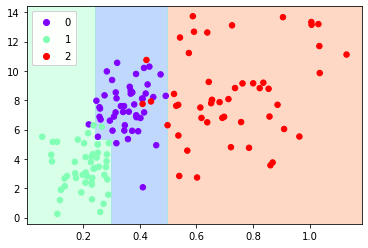

In [43]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=3), dfm, mirror=True)

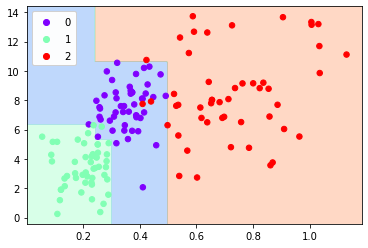

In [44]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4), dfm, mirror=True)

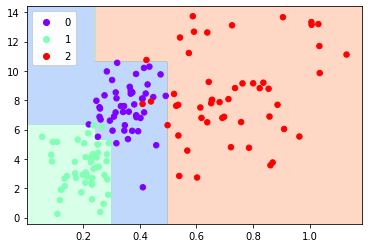

In [45]:
pert_data = perturb_data(dfm)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4), pert_data, mirror=True)

## Export tree data for Explainer

In [46]:
fields=["Height", "Diameter", "Family"]
dfm[fields]

,Height,Diameter,Family
0,5.516463,0.251167,apple
1,8.462498,0.420333,apple
2,8.539767,0.372501,apple
3,6.846023,0.387562,apple
4,7.174502,0.313854,apple
...,...,...,...
145,13.111942,0.725863,oak
146,11.698225,1.034884,oak
147,7.507775,0.613716,oak
148,7.753531,0.409282,oak


In [47]:
for i, row in dfm[fields].iterrows():
    print(row.Height)

5.516463142787906
8.462497517725062
8.539767456860035
6.846022662069858
7.174501838896365
9.971621183586578
7.9690416856760455
4.936676049961282
6.890820532701919
6.794155471867191
7.1753267223774495
2.0693833741501546
9.79633289171946
7.606045117777428
5.93269367078291
7.719919690403421
8.537835582540536
6.613498357388085
5.889706453233334
7.224957088801937
10.296750493318651
9.384204875775373
6.926145132384073
8.139012513639603
8.539767456860035
8.30298268349783
9.079930118696485
7.60283674272784
6.300692144442185
10.208286380321383
6.357543803406209
7.439238182779435
6.691300711361588
8.220573978804245
6.875108897471223
5.937194340862996
5.0745190834955824
5.920589181613834
5.3568896774983354
8.451036667447317
7.204687954850165
8.654247964660291
7.530498114953255
8.922007219556091
9.766504704242092
8.102340459857306
6.981073677170613
8.122556303448269
8.339061272301727
10.557796259192466
1.5650039173816919
2.257013528977101
3.4465251716969023
4.426343150180946
2.8394355731443466
2.7

In [48]:
def export_data(data, fields=["Height", "Diameter", "Family"]):
    
    out = []
    for i, row in data.iterrows():
        out.append({ "Height": row.Height, "Diameter": row.Diameter, "Family": row.Family })
        
    return out

In [49]:
export_data(dfm)

[{'Height': 5.516463142787906,
  'Diameter': 0.2511668935846272,
  'Family': 'apple'},
 {'Height': 8.462497517725062,
  'Diameter': 0.4203330538019373,
  'Family': 'apple'},
 {'Height': 8.539767456860035,
  'Diameter': 0.3725014034445392,
  'Family': 'apple'},
 {'Height': 6.846022662069858,
  'Diameter': 0.3875624398400911,
  'Family': 'apple'},
 {'Height': 7.174501838896365,
  'Diameter': 0.31385378927688,
  'Family': 'apple'},
 {'Height': 9.971621183586578,
  'Diameter': 0.2828088357805004,
  'Family': 'apple'},
 {'Height': 7.9690416856760455,
  'Diameter': 0.2458539011606311,
  'Family': 'apple'},
 {'Height': 4.936676049961282,
  'Diameter': 0.4575865011508566,
  'Family': 'apple'},
 {'Height': 6.890820532701919,
  'Diameter': 0.3081200576875144,
  'Family': 'apple'},
 {'Height': 6.794155471867191,
  'Diameter': 0.4018361520379268,
  'Family': 'apple'},
 {'Height': 7.1753267223774495,
  'Diameter': 0.4147104893586832,
  'Family': 'apple'},
 {'Height': 2.0693833741501546,
  'Diameter

In [52]:
def export_dict(decision_tree, feature_names=None):
    js = {}
    arr = []
    def node2str(tree, node_id, criterion):
        if not isinstance(criterion, six.string_types):
            criterion = "impurity"
        value = tree.tree_.value[node_id]
        if tree.tree_.n_outputs == 1:
            value = value[0, :]
        if tree.tree_.children_left[node_id] == sklearn.tree._tree.TREE_LEAF:
            # if end node
            return {"id": str(node_id),
                    "impurity": str(tree.tree_.impurity[node_id]),
                    "samples": str(tree.tree_.n_node_samples[node_id]),
                    "value": str(value),
                   "class":  str(value.argmax(axis=0))
                   } 
        else:
            if feature_names is not None:
                feature = feature_names[tree.tree_.feature[node_id]]
            else:
                feature = tree.tree_.feature[node_id]
            return {"id": str(node_id),
                    'children':[],
                    "name": f"{feature} <= {tree.tree_.threshold[node_id]:.4f}",
                    criterion: str(tree.tree_.impurity[node_id]),
                    "samples": str(tree.tree_.n_node_samples[node_id])
                   } 
    def recurse(tree, node_id, criterion, parent=None):
        left_child = tree.tree_.children_left[node_id]
        right_child = tree.tree_.children_right[node_id]
        js = node2str(tree, node_id, criterion)
        # if not end node, append left and right to children
        if left_child != sklearn.tree._tree.TREE_LEAF: 
            arr.append(js)
#             js['children'].append(recurse(tree, left_child, criterion=criterion, parent=node_id))
#             js['children'].append(recurse(tree, right_child,criterion=criterion,parent=node_id))
        return js
    if isinstance(decision_tree, sklearn.tree.DecisionTreeClassifier):
        js = recurse(decision_tree, 0, criterion="impurity")
    else:
        js = recurse(decision_tree.tree_, 0, criterion=decision_tree.criterion)
    return arr

In [53]:
tt = export_dict(tree_model, features)
tt

[{'id': '0',
  'children': [],
  'name': 'Height <= 0.4944',
  'impurity': '1.584962500721156',
  'samples': '150'}]

In [130]:
jsonfile_name = 'data/treedata.json'
with open(jsonfile_name, 'w') as f:
    json.dump(tt, f)